In [1]:
import os
import sys
from pathlib import Path
ROOT_PATH = Path.cwd().parent
sys.path.append(str(ROOT_PATH))
from typing import Optional

from hydra.utils import instantiate
from hydra import initialize_config_dir, compose

import cv2
import numpy as np
import skimage as sci
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torch

from src.models.unet import UNet
import nuclei_demo as dn

Configure paths

In [2]:
config_dir = str(ROOT_PATH / 'conf')
with initialize_config_dir(version_base=None, config_dir=config_dir):
    cfg = compose(config_name='config.yaml')

DATA_DIR = str(ROOT_PATH / cfg.paths.train_data)
CHECKPOINTS_PATH = ROOT_PATH / cfg.paths.checkpoints


Define functions to conviniently draw arrays 

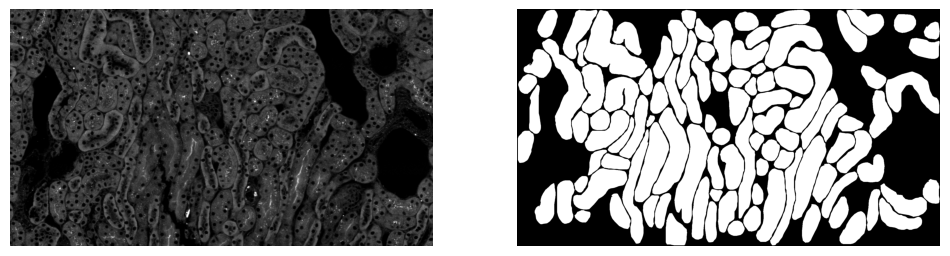

In [3]:
def draw_array(img_arr: np.array) -> None:
    plt.axis('off')
    plt.imshow(np.clip(img_arr, 0, 1500), cmap='gray')
    plt.show()
    return None

def draw_arrays(
        img_arrs: list[np.array], 
        ncols: Optional[int] = 2, 
        titles: Optional[str] = None,
        clip_pixel_value: Optional[int] = 1500,
    ) -> None:

    n_arrs = len(img_arrs)
    nrows = n_arrs // ncols + int(n_arrs % ncols != 0)
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*6, nrows*6), squeeze=False)


    for i, img in enumerate(img_arrs):
        row, col = i // ncols, i % ncols
        axs[row, col].imshow(np.clip(img, 0, clip_pixel_value), cmap='gray')
        if titles:
            axs[row, col].set_title(titles[i])
        axs[row, col].axis("off")
    plt.axis('off')
    
    return  None

image, mask, outlines = dn.read_image(DATA_DIR, 'Fused_S1_2.tif')
draw_arrays([image, mask])

Split single image with `N` tubules masks to `N` images with single tubule mask

In [15]:
print(f'Original masks shape: {mask.shape}')
masks = dn.masks_split_contours(mask)
print(f'Splitted masks shape: {masks.shape}')


Original masks shape: (1098, 1962)
Splitted masks shape: (104, 1098, 1962)


Draw example of an individual tubule

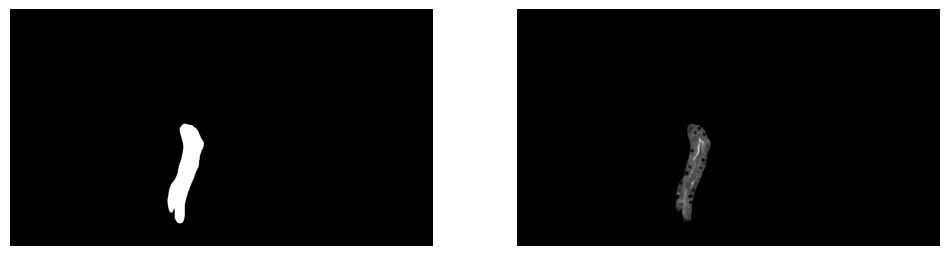

In [5]:
id = 43
draw_arrays([masks[id], image * masks[id]])

Create boundind box for each tubule. Each bbox is `(x_top, y_top, width, height)` array

In [6]:
bboxes = dn.masks2bboxes(masks)
print(f'bboxes shape: {bboxes.shape}')
bboxes[:4]

bboxes shape: (104, 4)


array([[ 976,  980,   79,   70],
       [ 690,  946,   98,  148],
       [1496,  937,  123,  151],
       [ 267,  932,   73,   56]])

Show bboxes

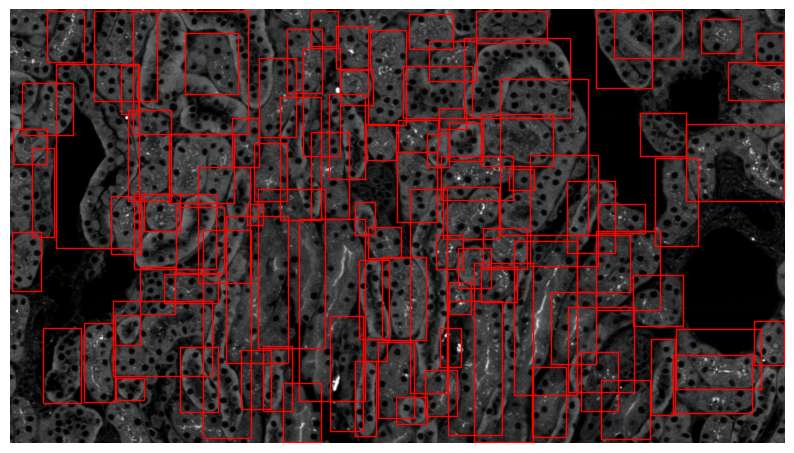

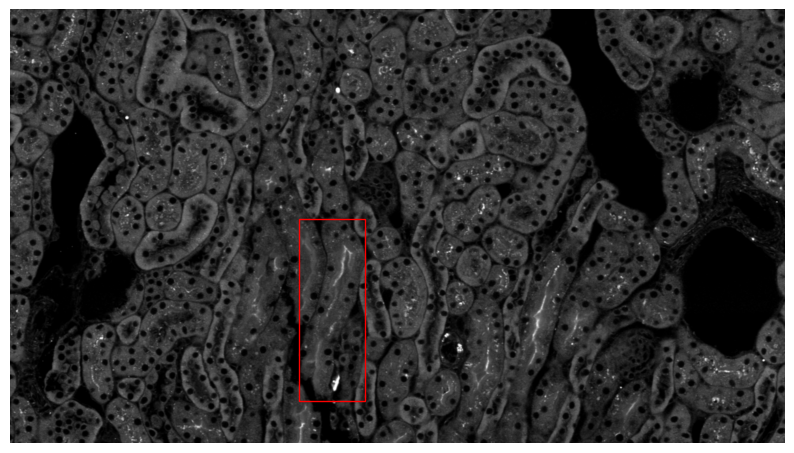

In [7]:
def draw_image_bboxes(
        image: np.array, 
        bboxes: np.array, 
        clip_pixel_values: Optional[bool] = True,
        fig_size: Optional[tuple] = (10, 10)
    ) -> None:
    # Create figure and axis
    fig, ax = plt.subplots(figsize=fig_size)

    # Draw main image
    ax.imshow(np.clip(image, 0, 1500), cmap='gray')

    # Add bounding boxes to the image
    for xmin, ymin, width, height in bboxes:
        rect = Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Show the plot
    plt.axis('off')
    plt.show()
    return None

draw_image_bboxes(image, bboxes)
draw_image_bboxes(image, [bboxes[43]])

Square crop tubules

Cropped image shape: (528, 528)


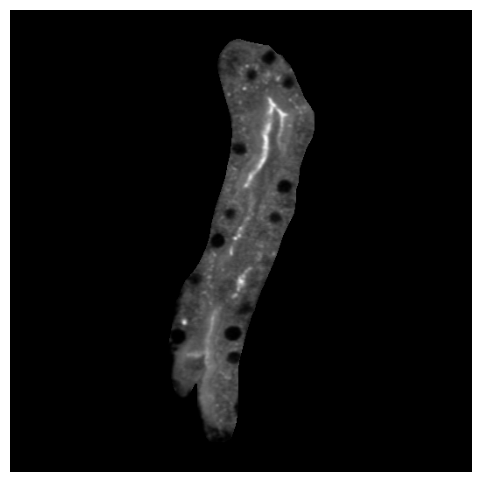

In [8]:
images = image * masks
img_cropped, bboxes_cropped = dn.crop_images_bboxes(images, bboxes)
img47 = img_cropped[43]
print(f'Cropped image shape: {img47.shape}')
draw_arrays([img47], ncols=1)

Load trained U-Net

In [9]:
model = UNet(1, 1)
checkpoint = str(CHECKPOINTS_PATH / f'unet_nuclei_epoch8.pth')
model.load_state_dict(torch.load(checkpoint))

<All keys matched successfully>

Predict nuclei masks for a single tubule

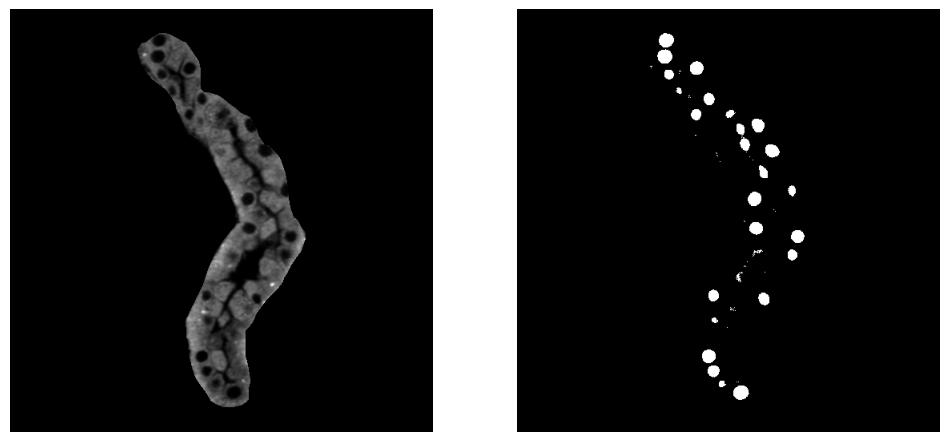

In [10]:
img_idx = 84
img = img_cropped[img_idx]
mask_pred = dn.predict(model, img)
draw_arrays([img, mask_pred])

Eliminate errors based on area value and $\frac{perimeter}{\sqrt{area}}$ ratio

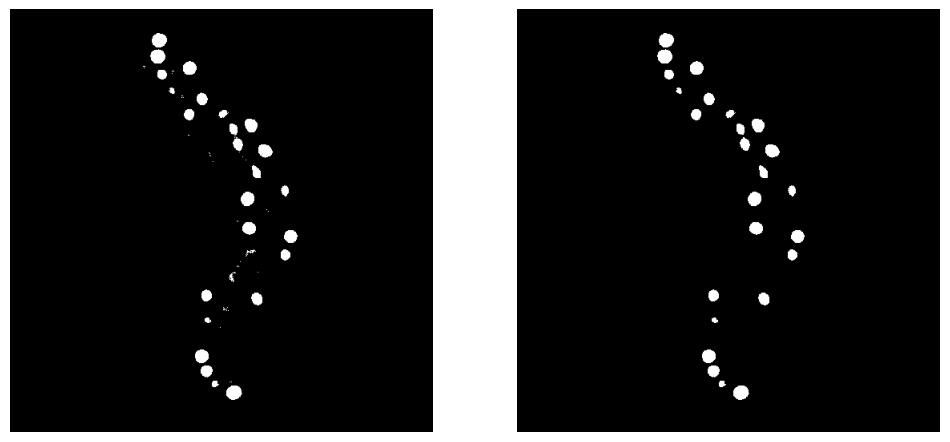

In [11]:
mask_pred_filtered, area_lst, perimeter_lst = dn.filter_nuclei(mask_pred)
draw_arrays([mask_pred, mask_pred_filtered])

To predict nuclei masks for the entire image, calculate s predictions for individual tubule crops, and then place them in the appropriate position on the bigger image

In [12]:
image_name = 'Fused_S1_2.tif'
mask_pred_full, areas, perimeters = dn.predict_image(model, DATA_DIR, image_name)

Loading images
Crop tubules


Predict masks: 100%|██████████| 104/104 [00:02<00:00, 39.85it/s]


Visualize the results with tubule outlines to distinguish between annotated and unannotated tubules.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


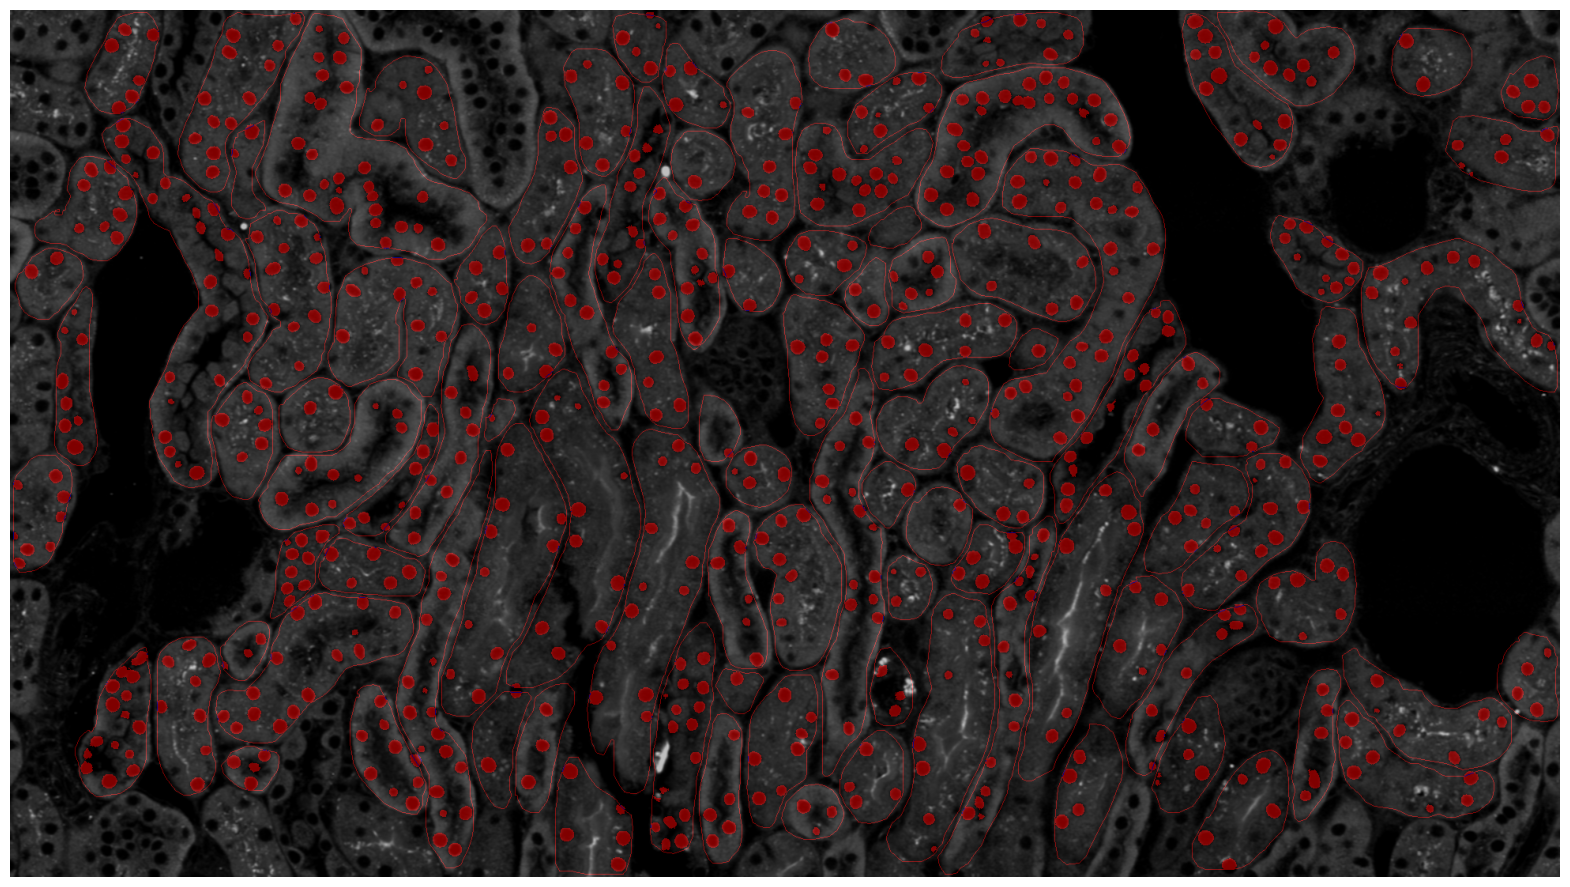

In [13]:
image, mask, outlines = dn.read_image(DATA_DIR, image_name)
dn.draw_nuclei(image, outlines, mask_pred_full)

Areas and Perimiters values distribution

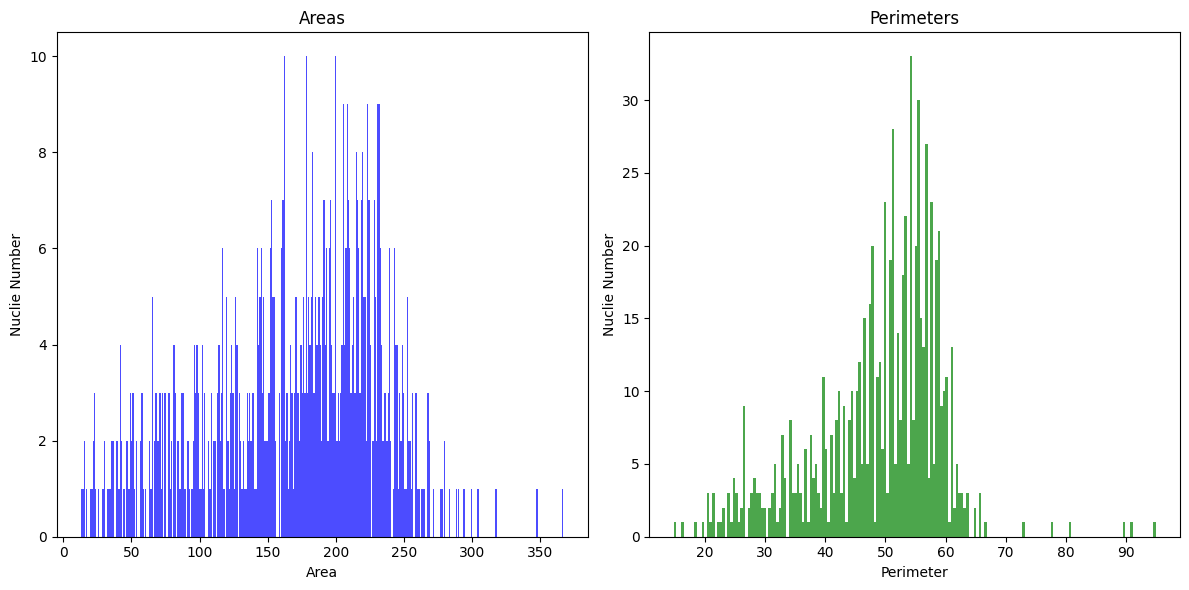

In [14]:
dn.draw_distributions(areas, perimeters)